使用多类逻辑回归进行多类分类（https://zh.gluon.ai/chapter_supervised-learning/softmax-regression-scratch.html）

![](https://zh.gluon.ai/_images/simple-softmax-net.png)

多类逻辑回归与线性回归的不同之处在于多类回归的输出有多个

#### 开始

获取数据

In [1]:
#导入项目根目录下的utils.py模块
import sys
sys.path.append('..')
import utils
# 使用gluon的data.vision模块下载数据集
# 注意，这里的数据下载网络可能会有问题。我的本机重试好几次还是下载不下来文件。
#改为从项目目录fashion-mnist下读取/改为从网络上手动下载文件，并放到默认的读取目录，我这里是 /home/tian/.mxnet/datasets/fashion-mnist/
from mxnet import gluon
from mxnet import ndarray as nd
def transform(data, label):
    return data.astype('float32') / 255, label.astype('float32')

#原始文件读取方式，可以添加root参数制定读取文件目录
mnist_train = gluon.data.vision.FashionMNIST(train=True, transform=transform)
mnist_test = gluon.data.vision.FashionMNIST(train=False, transform=transform)

In [2]:
data, label = mnist_train[0]
('example shap:', data.shape, 'label:', label)

('example shap:', (28, 28, 1), 'label:', 2.0)

查看样本内容与对应标签

In [3]:
import matplotlib.pyplot as plt

def show_images(images):
    #print(images)
    n = images.shape[0]
    _, figs = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        figs[i].imshow(images[i].reshape((28, 28)).asnumpy())
        figs[i].axes.get_xaxis().set_visible(False)
        figs[i].axes.get_yaxis().set_visible(False)
    plt.show()

def get_text_labels(label):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in label]

data, label = mnist_train[0:9]
show_images(data)
print(get_text_labels(label))

['pullover', 'ankle boot', 'shirt', 't-shirt', 'dress', 'coat', 'coat', 'sandal', 'coat']


数据读取

In [4]:
batch_size = 256
train_data = gluon.data.DataLoader(mnist_train, batch_size, shuffle=True) #随机样本组成的批量
test_data = gluon.data.DataLoader(mnist_test, batch_size, shuffle=False)

初始化模型参数

跟线性模型一样，每个样本会表示成一个向量。这里的数据是28 * 28 大小的图片，所以输入向量的长度是 28 * 28 = 784。因为要做多类分类，我们需要对每一个类预测这个样本属于此类的概率。因为这个数据集有10个类型，所以输出应该是长度为10的向量。这样，我们的权重将是一个 784 * 10 的矩阵。（这里解释了模型的输入输出向量的大小计算方式，以及权重矩阵）

In [5]:
num_inputs = 784
num_outputs = 10

W = nd.random_normal(shape=(num_inputs, num_outputs))
b = nd.random_normal(shape=num_outputs)

params = [W, b]

梯度

In [6]:
for param in params:
    param.attach_grad()

定义模型

在线性回归里，我们只需要输出一个标量 $ \hat y $ 使得尽可能的靠近目标值。但在多类逻辑回归里，我们需要属于每个类别的概率，这些概率需要值为正，而且加起来和为1。如果简单的使用 $ \hat y = \mathbf{W} x $ ，我们不能保证这一点。一个通常的做法是通过softmax函数（解释见此页后面）来将任意的输入归一化成合法的概率值。

In [7]:
from mxnet import nd
def softmax(X):
    exp = nd.exp(X)
    # 假设exp是矩阵，这里对行进行求和，并要求保留axis 1
    # 就是返回（nrows, 1） 形状的矩阵
    partition = exp.sum(axis=1, keepdims=True)
    return exp / partition

试一下softmax的效果

In [8]:
X = nd.random_normal(shape=(2, 5))
print(X)
X_prob = softmax(X)
print(X_prob)
print(X_prob.sum(axis=1))


[[-0.39157307  1.31661868 -0.43292624  0.71535987  0.92541558]
 [-0.90495086 -0.074684    0.82253999 -1.87851071  0.88588363]]
<NDArray 2x5 @cpu(0)>

[[ 0.07024596  0.38768554  0.06740031  0.21249865  0.26216954]
 [ 0.06539094  0.1500023   0.36792335  0.02470051  0.39198291]]
<NDArray 2x5 @cpu(0)>

[ 1.  1.]
<NDArray 2 @cpu(0)>


可以看到，对于随机的输入，softmax将每个元素都变成了非负数，并且每一行加起来的和为1.

定义模型

In [9]:
def net(X):
    # 这里X是一个三维的数据，使用reshape将三维变为2维数据
    return softmax(nd.dot(X.reshape((-1,num_inputs)), W) + b) # -1 表示让mxnet自动帮我们去求转换后的大小，这里是256即batch_size

损失函数

In [10]:
def cross_entropy(yhat, y):
    return - nd.pick(nd.log(yhat), y)

计算精度

In [11]:
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()

评估模型精度

In [12]:
def evaluate_accuracy(data_iterator, net):
    acc = 0
    for data, label in data_iterator:
        output = net(data)
        acc += accuracy(output, label)
    return acc / len(data_iterator)

In [13]:
evaluate_accuracy(test_data, net)

0.098046875000000006

训练

In [14]:
import sys
sys.path.append('..') # 这里是为了能引用到工程目录下的utils.py
from utils import SGD
from mxnet import autograd

learning_rate = .1

for epoch in range(5):
    train_loss = 0.
    train_acc = 0.
    for data, label in train_data:
        with autograd.record():
            output = net(data)
            loss = cross_entropy(output, label)
        loss.backward()
        #梯度下降
        SGD(params, learning_rate / batch_size)
        
        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)
    
    test_acc = evaluate_accuracy(test_data, net)
    print('Epoch %d. Loss: %f, Train acc %f, Test acc %f' %(epoch, train_loss / len(train_data), 
                                                            train_acc / len(train_data), test_acc))

Epoch 0. Loss: 3.514283, Train acc 0.458173, Test acc 0.593555
Epoch 1. Loss: 1.843634, Train acc 0.634924, Test acc 0.668359
Epoch 2. Loss: 1.533731, Train acc 0.682813, Test acc 0.697363
Epoch 3. Loss: 1.378882, Train acc 0.706721, Test acc 0.715430
Epoch 4. Loss: 1.276641, Train acc 0.722634, Test acc 0.727930


预测

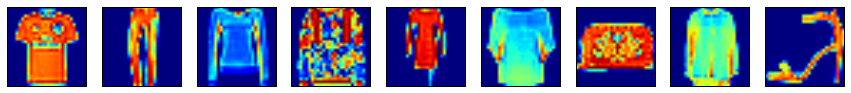

true labels
['t-shirt', 'trouser', 'pullover', 'pullover', 'dress', 'pullover', 'bag', 'shirt', 'sandal']
predicted labels
['shirt', 'trouser', 'shirt', 't-shirt', 'trouser', 'shirt', 'bag', 'shirt', 'sandal']


In [15]:
data, label = mnist_test[0:9]
show_images(data)
print('true labels')
print(get_text_labels(label))

predicted_labels = net(data).argmax(axis=1)
print('predicted labels')
print(get_text_labels(predicted_labels.asnumpy()))

[Softmax](https://zh.wikipedia.org/wiki/Softmax%E5%87%BD%E6%95%B0, 'Softmax wiki')
>Softmax函数，或称归一化指数函数。能将一个含任意实数的K维向量 $ z $ “压缩”到另一个K维实向量 $ \sigma(z) $ 中， 使得每一个元素的范围都在(0, 1) 之间，并且所有元素的和为1。该函数的形式通常按以下形式给出 $$ \sigma(z)_j = \frac{e^{z_j}} {\sum_{k=1}^{\mathbf{K}} e^{z_k}} \qquad \text {for j = 1, ..., K} $$
>在多项逻辑回归和线性判别分析中，函数的输入是从 $K$ 个不同的线性函数得到的结果，而样本向量 $\vec{x}$ 属于第 $ \mathbf{j}$ 个分类的概率为：$$ \mathbb{P}(y = j|{x}) = \frac{e^{x^Tw_j}}{\sum_{k=1}^{\mathbf{K}}e^{x^Tw_k}} $$

>例子：输入向量[1, 2, 3, 4, 1, 2, 3]对应的Softmax函数值为：[0.024, 0.064, 0.175, 0.475, 0.024, 0.064, 0.175]。（计算过程见下面代码）。输出向量中拥有最大权重的项对应着输入向量中的最大值“4”。这也显示了这个函数的通常意义：对向量进行归一化，凸显其中最大的值并抑制远低于最大值的其他分量。

In [16]:
# python 进行softmax计算代码(来源wiki)
import math
z = [1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0]
z_exp = [math.exp(i) for i in z]
print(z_exp)
sum_z_exp = sum(z_exp)
print(sum_z_exp)
softmax = [round(i / sum_z_exp, 3) for i in z_exp]
print(softmax)
print(sum(softmax))

[2.718281828459045, 7.38905609893065, 20.085536923187668, 54.598150033144236, 2.718281828459045, 7.38905609893065, 20.085536923187668]
114.98389973429897
[0.024, 0.064, 0.175, 0.475, 0.024, 0.064, 0.175]
1.0010000000000001
